In [2]:
#!pip install pandas_datareader

In [3]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [4]:
# Get the stock quote

df = web.DataReader("AAPL", data_source="yahoo", start="2012-01-01", end="2019-12-17")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591936
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659608
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800155
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933966
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913448
...,...,...,...,...,...,...
2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,66.701706
2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,66.871674
2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,67.780685


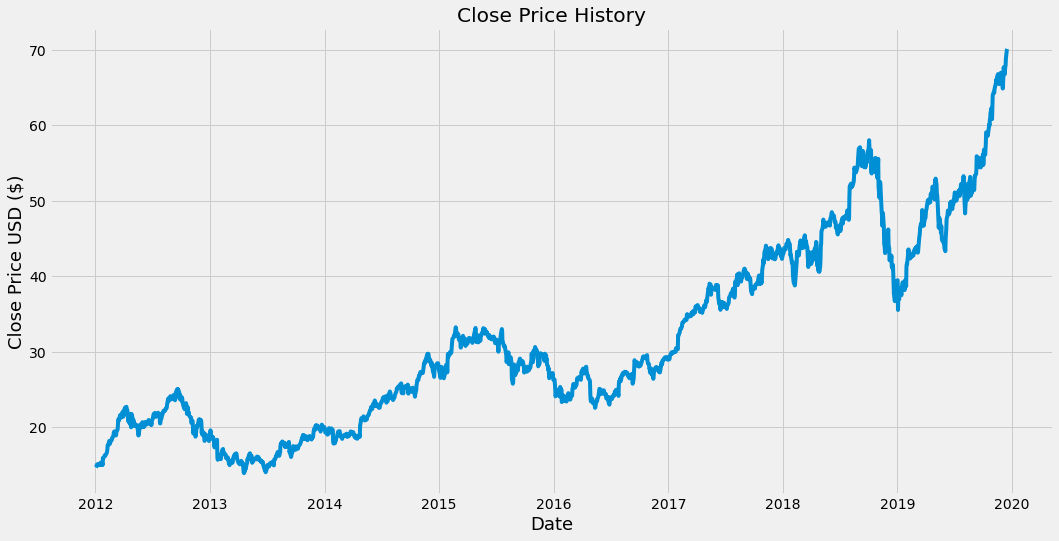

In [5]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [6]:
# Create a new dataframe with only the Close column
data = df.filter(["Close"])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

1603

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [8]:
# Create the training data set
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])


In [9]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data (the model needs a 3D object)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [11]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 29s 18ms/step - loss: 8.9210e-04


In [14]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Get the models predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.7264647674560547

<ipython-input-20-0395726749b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


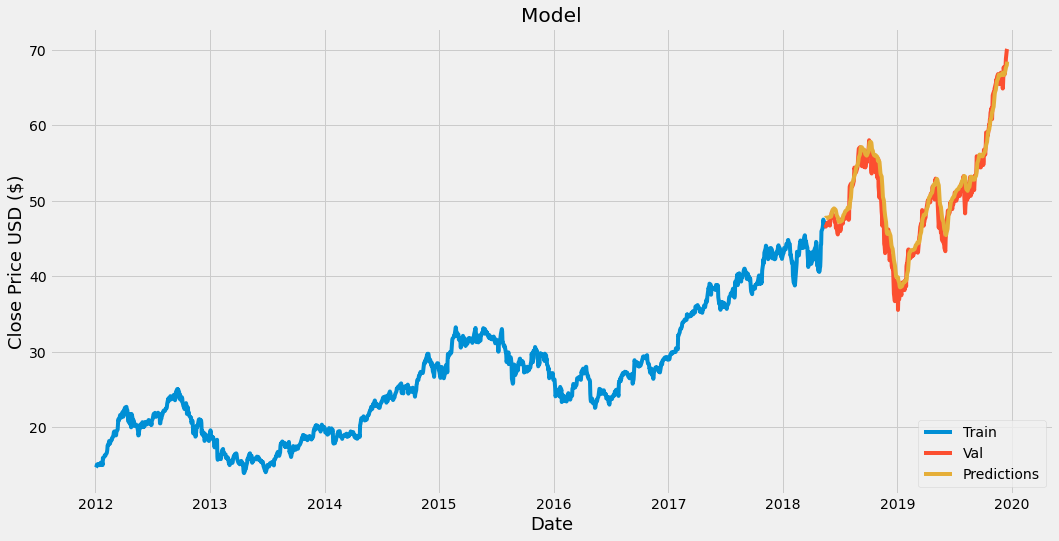

In [20]:
# Plot
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions

plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()